In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
name = 'test_model_2'

In [4]:
path = 'data/yrec_grid.h5'
h5f = h5py.File(path, 'r')

dset = h5f['data']
data = np.array(dset)
columns = dset.attrs['columns']

h5f.close()

In [5]:
df = pd.DataFrame(data, columns=columns)
del data

In [6]:
df.head()

,EEP,M/Msun,Age(Gyr),[Fe/H],fk,Rocrit,alphaMLT,Prot(days),log(Teff)(K),log(R/Rsun),log(Z/X)(surface)
0,1.000000,1.06,0.036089,0.1,6.0,2.75,1.5,0.374777,3.752937,-0.005539,-1.692670
1,1.045365,1.06,0.037402,0.1,6.0,2.75,1.5,0.383608,3.751863,-0.009092,-1.692682
2,1.067487,1.06,0.039110,0.1,6.0,2.75,1.5,0.395994,3.751114,-0.010804,-1.692698
3,1.069806,1.06,0.041330,0.1,6.0,2.75,1.5,0.412794,3.750794,-0.010895,-1.692721
4,1.079711,1.06,0.044216,0.1,6.0,2.75,1.5,0.435389,3.750821,-0.010110,-1.692753


In [7]:
mask = df['Prot(days)'] == 0
df.drop(df.loc[mask].index, inplace=True)

In [8]:
# df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
df['[Fe/H](surface)'] = df['log(Z/X)(surface)'] - np.log10(SOLAR_ZX)

In [9]:
df['log(Prot)(days)'] = np.log10(df['Prot(days)'])

In [10]:
df['log(Age)(Gyr)'] = np.log10(df['Age(Gyr)'])

In [11]:
# non_diff = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].to_numpy() == df.loc[df['EEP'] == 2, '[Fe/H](surface)'].to_numpy()
# np.sum(non_diff)

In [12]:
# start = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].index.to_numpy()
# stop = df.loc[df['EEP'] == 3, '[Fe/H](surface)'].index.to_numpy()

In [13]:
# non_diff_idx = np.concatenate([np.arange(st, sp+1, dtype=int) for st, sp in zip(start[non_diff], stop[non_diff])])

In [14]:
# len(non_diff_idx) / len(df)

In [15]:
# len(df) - len(non_diff_idx)

In [16]:
# df.drop(non_diff_idx, inplace=True)

In [17]:
# len(df)

In [18]:
random_state = 2

train = df.sample(frac=0.8, random_state=random_state)
test = df.drop(train.index)

In [19]:
print('Train length = ', len(train))
print('Test length = ', len(test))

Train length =  38447873
Test length =  9611968


In [20]:
del df

In [21]:
input_cols = ['log(Age)(Gyr)', 'M/Msun', '[Fe/H]', 'alphaMLT', 'fk', 'Rocrit']
output_cols = ['log(Teff)(K)', 'log(R/Rsun)', '[Fe/H](surface)', 'log(Prot)(days)']

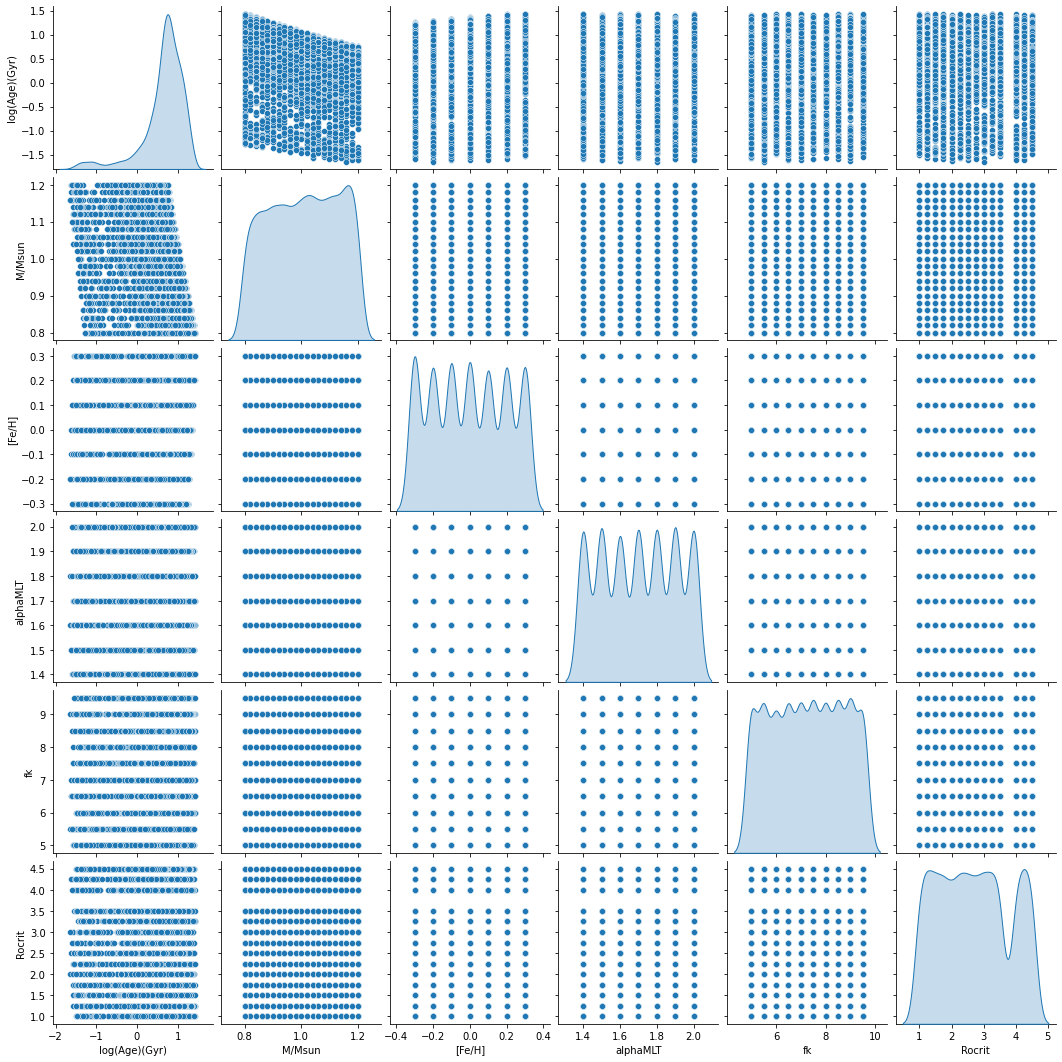

In [22]:
sns.pairplot(train[input_cols].sample(10000), diag_kind='kde');

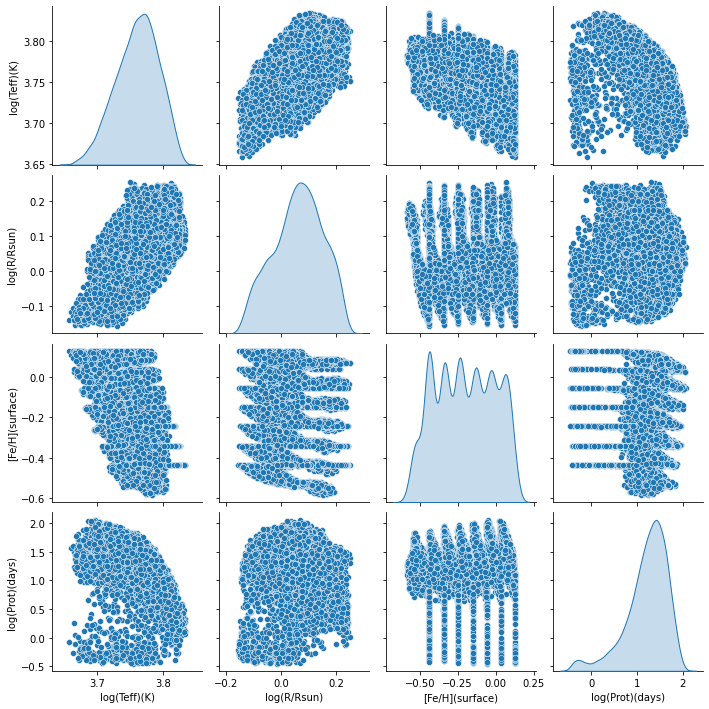

In [23]:
sns.pairplot(train[output_cols].sample(10000), diag_kind='kde');

In [24]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

In [25]:
input_mean = input_normalizer.mean.numpy()
input_var = input_normalizer.variance.numpy()
for col, mean, var in zip(input_cols, input_mean, input_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Age)(Gyr)  : 6.385e-01, 2.842e-01
M/Msun         : 1.008e+00, 1.474e-02
[Fe/H]         : -2.550e-03, 3.995e-02
alphaMLT       : 1.700e+00, 4.003e-02
fk             : 7.250e+00, 2.062e+00
Rocrit         : 2.679e+00, 1.173e+00


In [26]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

In [27]:
output_mean = output_normalizer.mean.numpy()
output_var = output_normalizer.variance.numpy()
for col, mean, var in zip(output_cols, output_mean, output_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Teff)(K)   : 3.761e+00, 1.023e-03
log(R/Rsun)    : 6.035e-02, 8.026e-03
[Fe/H](surface): -2.013e-01, 3.560e-02
log(Prot)(days): 1.195e+00, 2.106e-01


In [28]:
output_rescaler = preprocessing.Rescaling(scale=np.sqrt(output_var), 
                                          offset=output_mean)

In [29]:
def build_model(n_neurons, n_hidden, activation='elu', l2_reg=0.0):
    reg = regularizers.L2(l2_reg)
    hidden_layers = [layers.Dense(n_neurons, 
                                  activation=activation, 
                                  kernel_regularizer=reg) for layer in range(n_hidden)]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    model = keras.Sequential(all_layers)
    return model

In [30]:
model = build_model(128, 6, l2_reg=0.0)

In [31]:
model.save(f'data/models/{name}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: data/models/test_model_2/assets


In [32]:
learning_rate = 1e-4
momentum = 0.999

model.compile(loss='mean_squared_error',
#              optimizer=keras.optimizers.SGD(learning_rate, momentum=momentum),
             optimizer=keras.optimizers.Adam(learning_rate)
             )

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 128)               896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1

In [34]:
batch_size = 8192*2

print('Number of batches:', len(train)//batch_size)
print('Remainder:', len(train)%batch_size)

Number of batches: 2346
Remainder: 11009


In [38]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=0.2,
    batch_size=batch_size,
    verbose=0, epochs=500,
)

CPU times: user 2h 50min 28s, sys: 16min 15s, total: 3h 6min 44s
Wall time: 1h 5min 39s


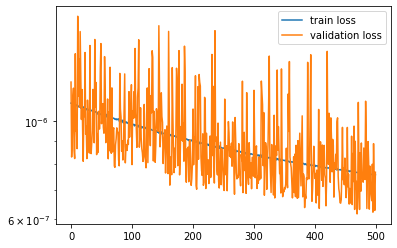

In [39]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')

plt.yscale('log')
plt.legend()

In [41]:
model.save(f'data/models/{name}')

INFO:tensorflow:Assets written to: data/models/test_model_2/assets


In [42]:
pred = pd.DataFrame(model.predict(test[input_cols], batch_size=batch_size), columns=output_cols)
pred.head()

,log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days)
0,3.751979,-0.007417,-0.053902,-0.430891
1,3.753035,-0.005458,-0.055051,0.018721
2,3.753283,-0.004940,-0.055591,0.170516
3,3.754223,0.000778,-0.059816,0.798608
4,3.754778,0.003915,-0.062720,0.889598


In [43]:
truth = test[output_cols].reset_index(drop=True)
error = truth - pred
frac_error = (truth - pred) / truth

In [44]:
truth.head()

,log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days)
0,3.752937,-0.005539,-0.054398,-0.426228
1,3.752855,-0.005913,-0.055013,0.025122
2,3.753089,-0.005414,-0.055218,0.175681
3,3.754258,0.001065,-0.060013,0.800040
4,3.754744,0.004095,-0.062651,0.890828


In [46]:
log_cols = ['log(Teff)(K)', 'log(R/Rsun)', 'log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [47]:
error.head()

,log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days),10^log(Teff)(K),10^log(R/Rsun),10^log(Prot)(days)
0,0.000958,0.001878,-0.000496,0.004663,12.472519,0.004260,0.004003
1,-0.000180,-0.000455,0.000038,0.006401,-2.344135,-0.001034,0.015502
2,-0.000193,-0.000474,0.000373,0.005165,-2.522174,-0.001078,0.017717
3,0.000035,0.000287,-0.000197,0.001432,0.455639,0.000663,0.020778
4,-0.000034,0.000179,0.000069,0.001230,-0.444279,0.000416,0.021995


In [48]:
error.mean()

log(Teff)(K)          0.000004
log(R/Rsun)          -0.000032
[Fe/H](surface)      -0.000011
log(Prot)(days)       0.000154
10^log(Teff)(K)       0.047760
10^log(R/Rsun)       -0.000078
10^log(Prot)(days)   -0.010375
dtype: float64

In [49]:
error.std()

log(Teff)(K)          0.000209
log(R/Rsun)           0.000374
[Fe/H](surface)       0.000431
log(Prot)(days)       0.001634
10^log(Teff)(K)       2.826447
10^log(R/Rsun)        0.001080
10^log(Prot)(days)    0.072018
dtype: float64

In [50]:
frac_error.mean()

log(Teff)(K)          0.000001
log(R/Rsun)          -0.000015
[Fe/H](surface)       0.000137
log(Prot)(days)      -0.000085
10^log(Teff)(K)       0.000009
10^log(R/Rsun)       -0.000074
10^log(Prot)(days)    0.000348
dtype: float64

In [51]:
frac_error.std()

log(Teff)(K)          0.000055
log(R/Rsun)           0.955523
[Fe/H](surface)       0.537104
log(Prot)(days)       0.569780
10^log(Teff)(K)       0.000481
10^log(R/Rsun)        0.000860
10^log(Prot)(days)    0.003761
dtype: float64

In [52]:
from scipy import stats

In [53]:
pd.Series(stats.median_abs_deviation(error), error.columns)

log(Teff)(K)          0.000101
log(R/Rsun)           0.000142
[Fe/H](surface)       0.000214
log(Prot)(days)       0.000805
10^log(Teff)(K)       1.326422
10^log(R/Rsun)        0.000366
10^log(Prot)(days)    0.027027
dtype: float64

In [54]:
pd.Series(stats.median_abs_deviation(frac_error), frac_error.columns)

log(Teff)(K)          0.000027
log(R/Rsun)           0.001888
[Fe/H](surface)       0.001142
log(Prot)(days)       0.000678
10^log(Teff)(K)       0.000231
10^log(R/Rsun)        0.000326
10^log(Prot)(days)    0.001852
dtype: float64

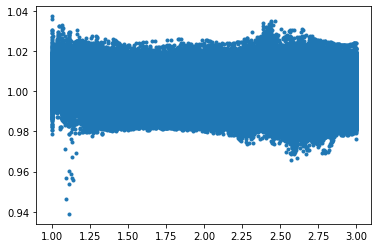

In [56]:
plt.plot(test['EEP'], 10**error['log(Prot)(days)'], '.');

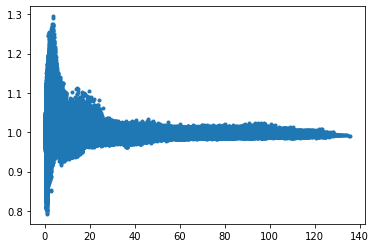

In [136]:
plt.plot(10**truth['log(Prot)(days)'], 10**error['log(Prot)(days)'], '.');

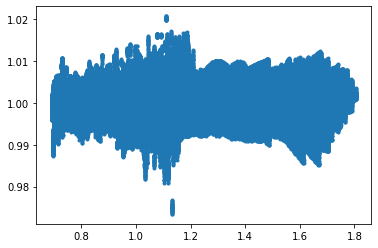

In [137]:
plt.plot(10**truth['log(R/Rsun)'], 10**error['log(R/Rsun)'], '.');

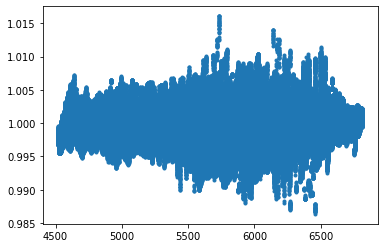

In [138]:
plt.plot(10**truth['log(Teff)(K)'], 10**error['log(Teff)(K)'], '.');

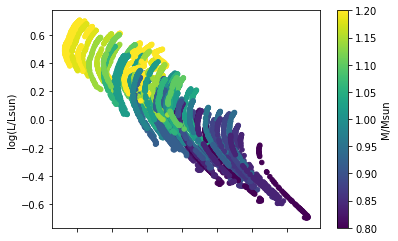

In [139]:
ax = test.iloc[:5000].plot(x='log(Teff)(K)', y='log(L/Lsun)', c='M/Msun', cmap='viridis', kind='scatter')

ax.invert_xaxis();